In [1]:
from pathlib import Path
import json

%matplotlib inline
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import model_utils
import plot_utils

from custom_datasets import PascalMultiClassDataset
from custom_layers import AdaptiveConcatPool, Flatten

In [2]:
DATA_DIR = Path('../data/pascal')
JPEG_DIR = DATA_DIR/'VOCdevkit/VOC2007/JPEGImages'
CSVS_DIR = DATA_DIR/'csvs'
data = json.load((DATA_DIR/'pascal_train2007.json').open())

DATA_IMAGES, DATA_TYPE, DATA_ANNOTATIONS, DATA_CATEGORIES = data['images'], data['type'], data['annotations'], data['categories']

category_dic = {x['id']:x['name'] for x in DATA_CATEGORIES}
jpeg_dic = {x['id']:x for x in DATA_IMAGES}

annotations_dic = defaultdict(lambda : [])
for ann in DATA_ANNOTATIONS:
    if ann['ignore']==0:
        annotations_dic[ann['image_id']].append((ann['bbox'],ann['category_id'])) 

In [ ]:
!ls DA

# To create multi class csv data
multi_class_csv_data = { 'file_name': [], 'category': [] }

for file in DATA_IMAGES:
    multi_class_csv_data['file_name'].append(file['file_name'])
    annotations = annotations_dic[file['id']]
    unique_class_ids = set([ann[1] for ann in annotations])
    multi_class_csv_data['category'].append(' '.join(category_dic[id] for id in unique_class_ids))
    
df = pd.DataFrame(multi_class_csv_data) 
df.to_csv(CSVS_DIR/'multi_class_classifier.csv', index=False)

In [11]:
multi_class = pd.read_csv(CSVS_DIR/'multi_class_classifier.csv')

In [12]:
bs = 64
sz = 224
n_epochs = 5
lr = 0.001

train_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor()
])

In [13]:
pas_multi_train_dl = torch.utils.data.DataLoader(
    PascalMultiClassDataset(CSVS_DIR/'multi_class_classifier.csv', JPEG_DIR, category_dic, train_tfms), 
    bs, 
    shuffle=True)

In [8]:
custom_head = nn.Sequential(
        AdaptiveConcatPool(),
        Flatten(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.25),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, 20),
        nn.Sigmoid()
    )

model = model_utils.get_resnet34_model_with_custom_head(custom_head)
model = model.to(device)

In [17]:
model.train()
n_epochs = 5
lr = 0.0005
loss_fn = nn.BCELoss()
pred_threshold = 0.4
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

total_steps = 0
for e in range(n_epochs):
    for batch, label_logits in pas_multi_train_dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        label_logits = label_logits.to(device)
        
        preds_probs = model(batch)
        loss = loss_fn(preds_probs, label_logits)
                 
        loss.backward()
        optimizer.step()
        
        pred_label_logits = (preds_probs >= pred_threshold).float()

        total_steps +=1
                                                        
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(pas_multi_train_dl))

Epoch [1/5], Iteration [1/40], Loss: 0.0491
Epoch [1/5], Iteration [10/40], Loss: 0.0433
Epoch [1/5], Iteration [20/40], Loss: 0.0371
Epoch [1/5], Iteration [30/40], Loss: 0.0490
Epoch [1/5], Iteration [0/40], Loss: 0.0745
Epoch [2/5], Iteration [1/40], Loss: 0.0391
Epoch [2/5], Iteration [10/40], Loss: 0.0553
Epoch [2/5], Iteration [20/40], Loss: 0.0601
Epoch [2/5], Iteration [30/40], Loss: 0.0448
Epoch [2/5], Iteration [0/40], Loss: 0.0604
Epoch [3/5], Iteration [1/40], Loss: 0.0554
Epoch [3/5], Iteration [10/40], Loss: 0.0423
Epoch [3/5], Iteration [20/40], Loss: 0.0426
Epoch [3/5], Iteration [30/40], Loss: 0.0479
Epoch [3/5], Iteration [0/40], Loss: 0.0428
Epoch [4/5], Iteration [1/40], Loss: 0.0526
Epoch [4/5], Iteration [10/40], Loss: 0.0644
Epoch [4/5], Iteration [20/40], Loss: 0.0418
Epoch [4/5], Iteration [30/40], Loss: 0.0444
Epoch [4/5], Iteration [0/40], Loss: 0.1427
Epoch [5/5], Iteration [1/40], Loss: 0.0353
Epoch [5/5], Iteration [10/40], Loss: 0.0447
Epoch [5/5], Iterat

In [22]:
!ls

combined_model_val_77.5.ckpt		 model_utils.py
custom_datasets.py			 multi_class.ckpt
custom_layers.py			 multi-class-classifier.ipynb
custom_transforms.py			 pascal-from-scratch.ipynb
largest-item-bbox.ipynb			 plot_utils.py
largest-item-bbox-plus-classifier.ipynb  __pycache__
largest-item-bbox-plus-classifier.py	 Saved Tensors
largest-item-classifier.ipynb		 test_images
logger.py				 Untitled.ipynb
logs


In [18]:
torch.save(model.state_dict(), 'multi_class.ckpt')

In [28]:
model.load_state_dict(torch.load(DATA_DIR/'my-models/multi_class.ckpt')) # , map_location='cpu'

In [29]:
pred_threshold = 0.4

In [19]:
pred_probs, batch, label_logits = model_utils.get_model_predictions_on_a_sample_batch(model, pas_multi_val_dl)
pred_label_logits = (preds_probs >= pred_threshold).float()

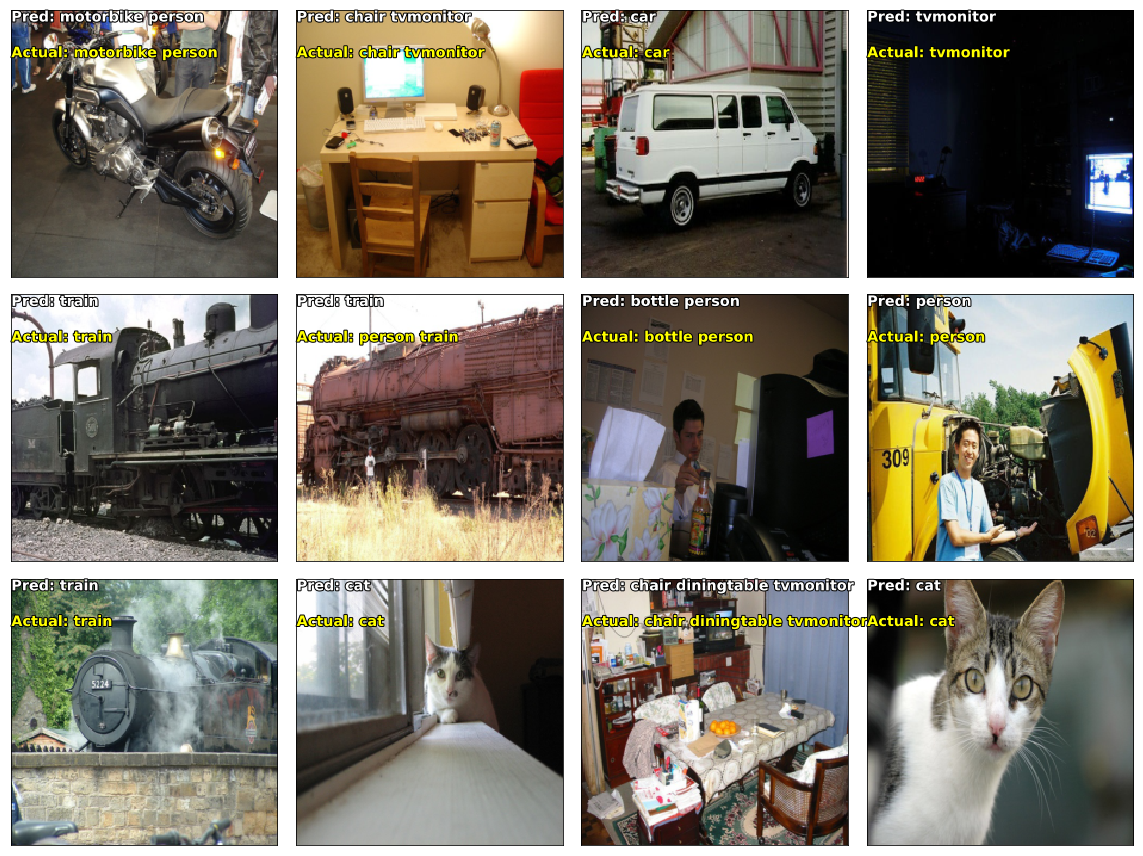

In [21]:
plot_utils.plot_model_predictions_on_sample_batch(batch.cpu(), pred_label_logits.cpu(), label_logits.cpu(), 
                                                        pas_multi_train_dl.dataset.get_cat_labels)

In [18]:
#predictions, actual_instances, correct_predictions = get_class_wise_metrics(model, pas_multi_val_dl, pred_threshold)

#torch.save((predictions, actual_instances, correct_predictions), './Saved Tensors/class_wise_metrics_on_val_ds.pt')

predictions, actual_instances, correct_predictions = torch.load('./Saved Tensors/class_wise_metrics_on_val_ds.pt')

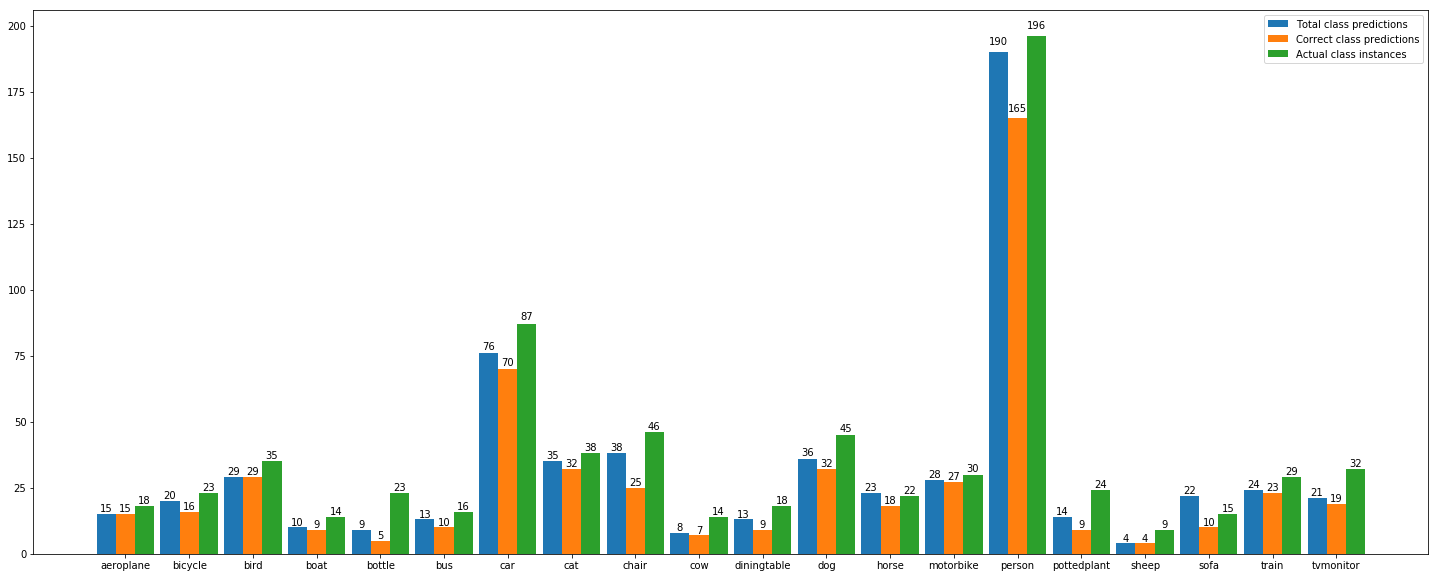

In [21]:
cats = list(pas_multi_train_dl.dataset.id_to_cat.values())
n_classes = len(cats)
plot_utils.plot_class_wise_preds_gt_true_preds(predictions, actual_instances, correct_predictions, cats)    

In [24]:
#ds_pred_scores, ds_gt_label_logits = get_concat_pred_scores_and_label_logits(model, pas_multi_val_dl)

#torch.save((ds_pred_scores, ds_gt_label_logits), './Saved Tensors/val_ds_pred_scores_and_label_logits.pt')

ds_pred_scores, ds_gt_label_logits = torch.load('./Saved Tensors/val_ds_pred_scores_and_label_logits.pt')

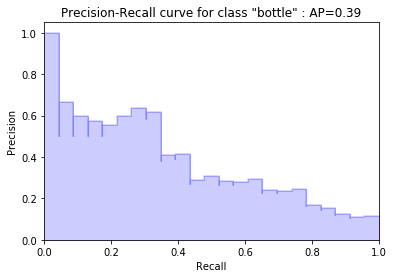

In [25]:
plot_utils.plot_class_precision_recall_curve(4, cats, ds_gt_label_logits, ds_pred_scores)    

In [26]:
precision, recall, average_precision = plot_utils.get_graph_data_for_multi_class_pr_curves(ds_gt_label_logits, ds_pred_scores, len(cats))

Average precision score, micro-averaged over all classes: 0.87


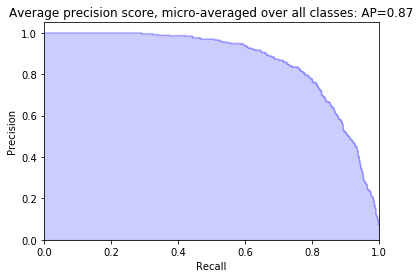

In [27]:
plot_utils.plot_average_precision_score_over_all_classes(precision, recall, average_precision)    

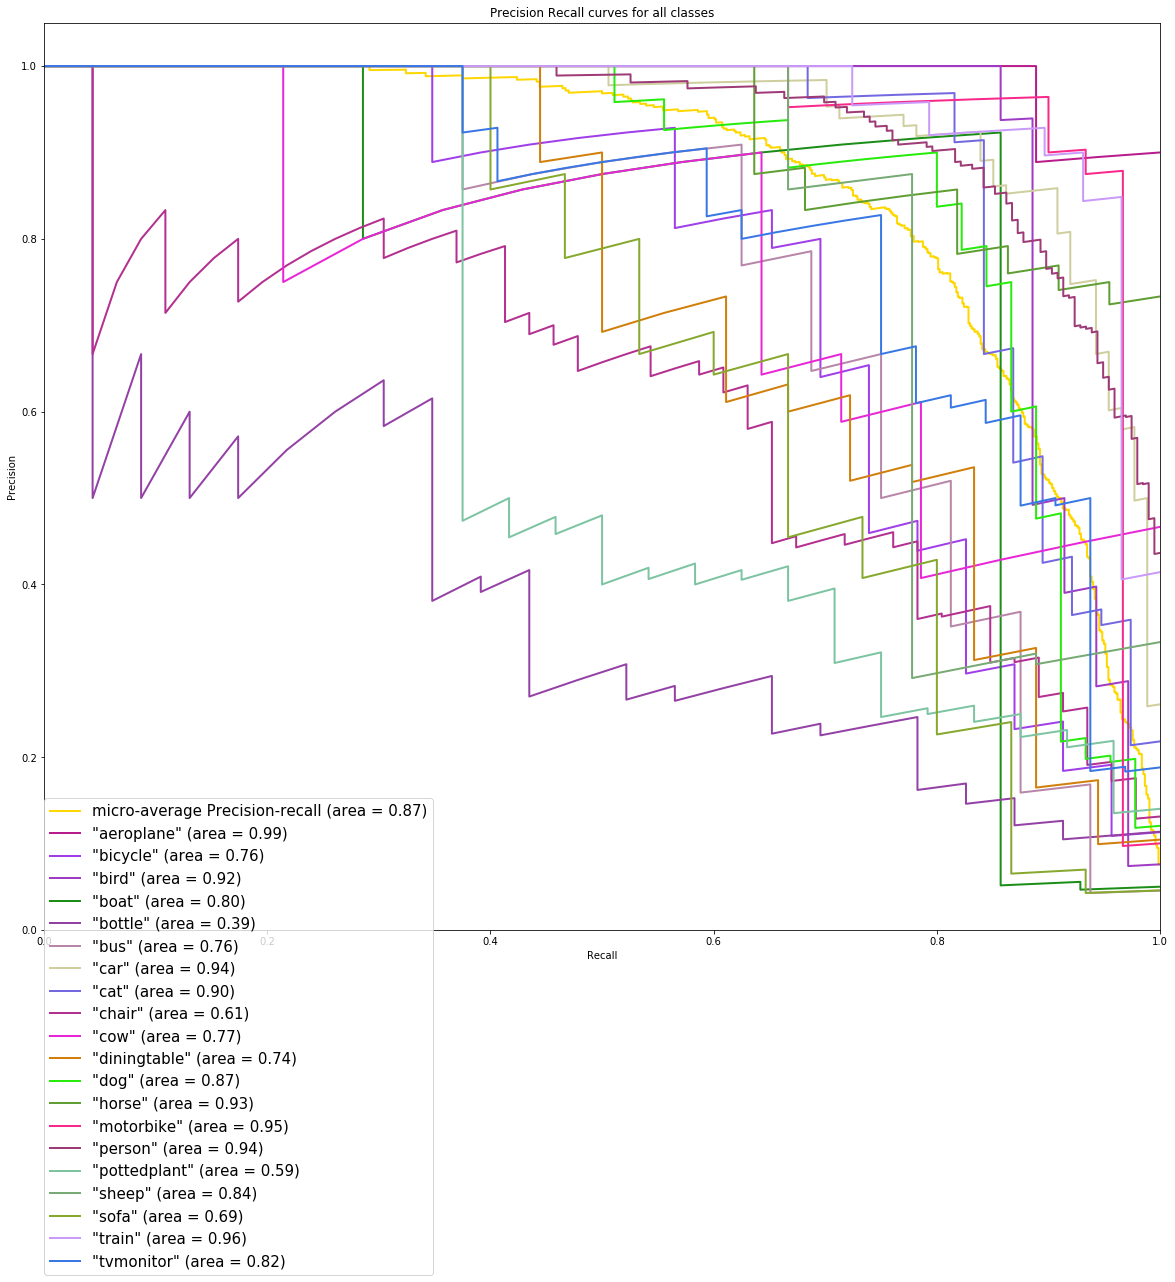

In [28]:
plot_utils.plot_precision_recall_curves_for_multi_class_labels(precision, recall, average_precision, cats)

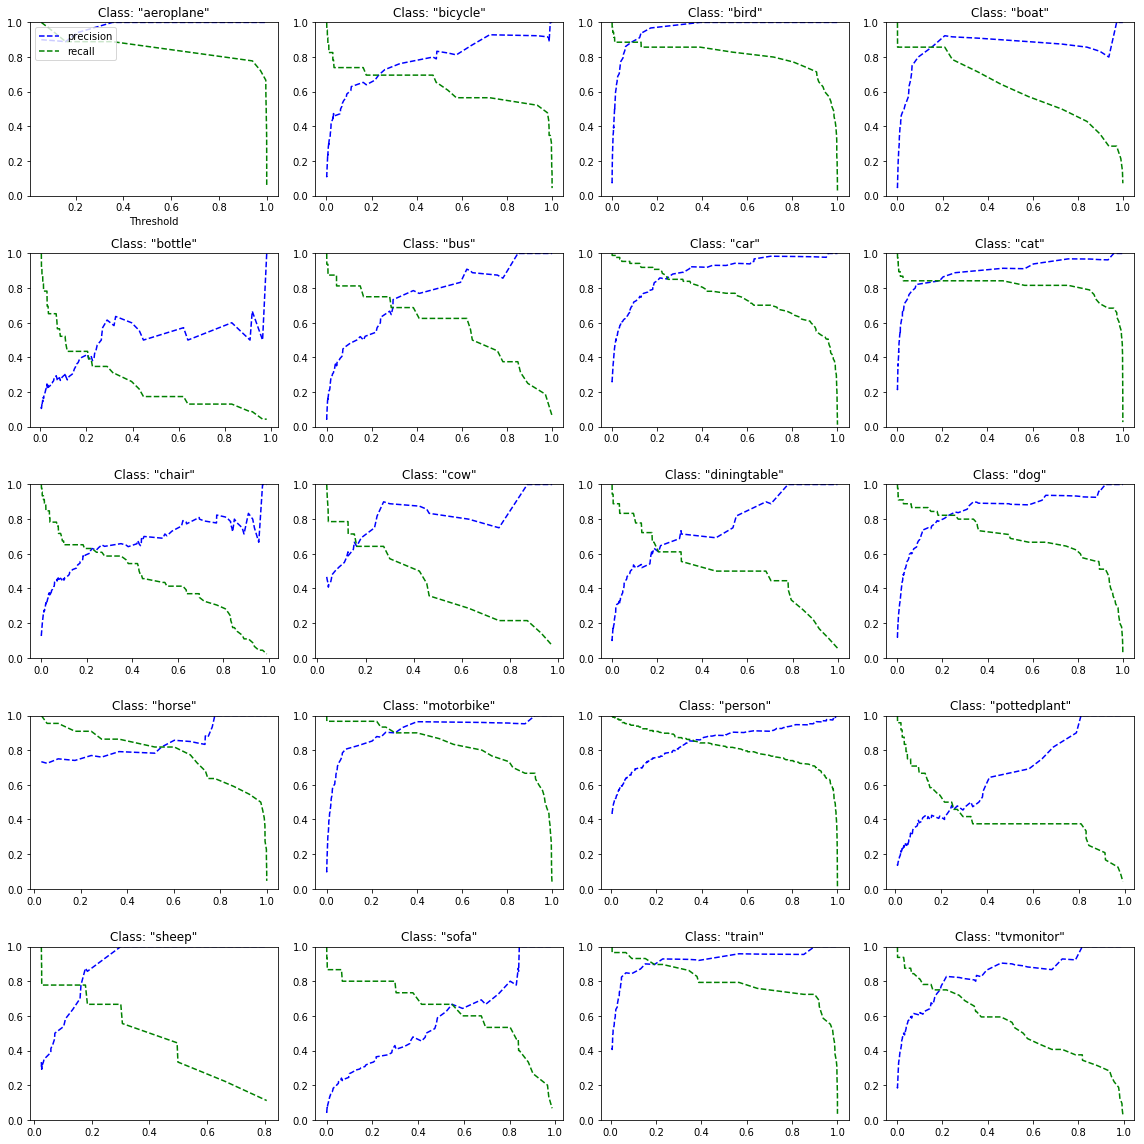

In [29]:
plot_utils.plot_precision_recall_vs_threshold_for_all_classes(n_classes, ds_gt_label_logits, ds_pred_scores, cats)